In [1]:
#contains HM Land Registry data © Crown copyright and database right 2017. This data is licensed under the Open Government Licence v3.0

%matplotlib inline

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 7

In [3]:
import pandas as pd
from pandas import DataFrame
from pandas import Series
import numpy as np
import matplotlib.pylab as plt
from matplotlib import pyplot
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [4]:
data_bruglaries_area = pd.read_csv('PostcodeHouseprice.csv', index_col='PostCode', header=0)

In [5]:
data2018=data_bruglaries_area[data_bruglaries_area.Year == 2018] ##dta just for 2018

In [6]:
c={'number_of_burglaries':'mean_number_of_burglaries', 'avg(price)': 'price'}
data2018b=data2018.groupby([data2018.index.name]).agg({'number_of_burglaries': 'mean', 'avg(price)': 'mean'}).rename(columns=c)
#used mean for number of burglaries because some postcodes dont have data for all 7 months of 2018

In [7]:
#split number of burglaries into intervals
data2018b["n_burg_categories"]=pd.cut(np.array(data2018b.mean_number_of_burglaries),[0,5,10,50,100,500,700,2000,5000])

In [8]:
data2018b.corr(method ='pearson') 
#correlation coefficient is almost 0, so from the Pearson corr we can say that number of burglaries is not affected 
#by affluence. But, problem with Pearson correlation is that is affected by the extreme values.


,mean_number_of_burglaries,price
mean_number_of_burglaries,1.0000,0.0096
price,0.0096,1.0000


In [9]:
data2018b.corr(method ='spearman')
#correlation is close to zero. so both ours correlations tell us that there is almost
#no correlation between number of burglaries and house prices

,mean_number_of_burglaries,price
mean_number_of_burglaries,1.00000,0.01003
price,0.01003,1.00000


Text(0.5, 1.0, 'Association between average number of burglaries and house prices')

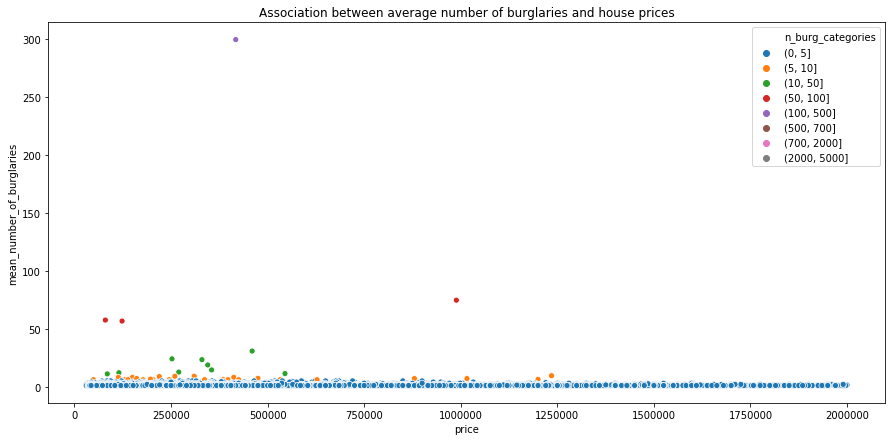

In [10]:
g = sns.scatterplot(x="price", y="mean_number_of_burglaries",
                    hue="n_burg_categories", data=data2018b)

g.set_title("Association between average number of burglaries and house prices")
#from the graph it is evident that there is small connection between number of burglaries and areas of 
#relative deprivation althought, biggest number of burglaries that stands out is at middle area.



In [11]:
#filter postcodes with data for all 7 months in 2018
burglaries2018= data2018.groupby([data2018.index.name]).agg({'Month': 'count'})
burglaries2018=burglaries2018.reset_index(level='PostCode')
burglaries2018=burglaries2018[burglaries2018['Month']== 7]

pc2=burglaries2018['PostCode'].to_numpy() #all postcodes that have data for 7 months

In [12]:
data2018=data2018.reset_index(level='PostCode')
data_clean= data2018[data2018.PostCode.isin(pc2)] #filtered 2018 data


In [13]:
data2018_clean=data_clean.groupby('PostCode').agg({'number_of_burglaries': 'sum', 'avg(price)': 'mean'})


Text(0.5, 1.0, 'Association between number of burglaries and house prices in 2018')

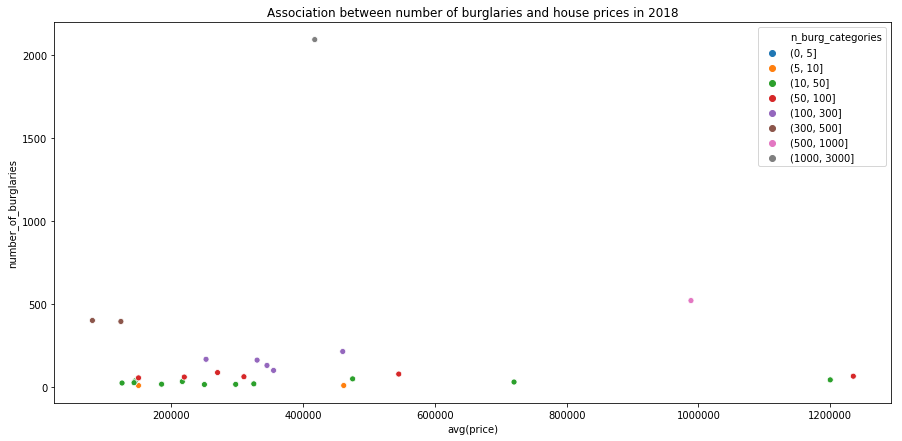

In [14]:
data2018_clean["n_burg_categories"]=pd.cut(np.array(data2018_clean.number_of_burglaries),[0,5,10,50,100,300,500,1000,3000])
g =sns.scatterplot(x="avg(price)", y="number_of_burglaries",
                   hue="n_burg_categories",data=data2018_clean);
g.set_title("Association between number of burglaries and house prices in 2018")

#from the graph it is evident that there small amount of burglaries happen on this areas drugin all 7 months

In [15]:
c={'number_of_burglaries':'number_of_burglaries', 'avg(price)': 'price'}
data = pd.read_csv('PostcodeHouseprice.csv', header=0,parse_dates=[[1,2]], index_col=[0]).rename(columns=c)
#data for time series

In [16]:
burglaries_trend=data.groupby([data.index.name])['number_of_burglaries'].sum()

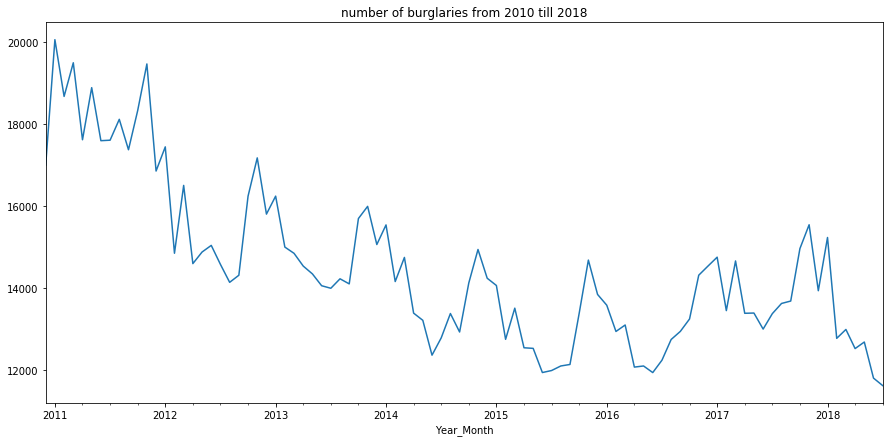

In [17]:
burglaries_trend.plot()
plt.title('number of burglaries from 2010 till 2018')
pyplot.show()

In [18]:
rolmean = burglaries_trend.rolling(12).mean()
rolstd = burglaries_trend.rolling(12).std()

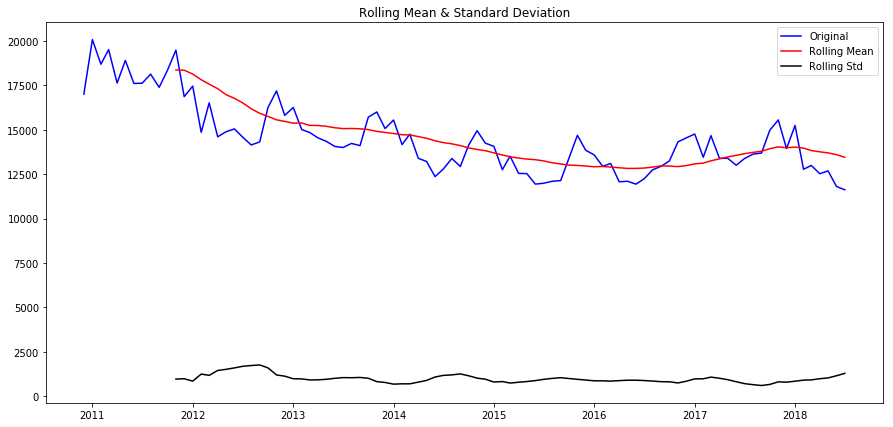

In [19]:
#visualisation test for stationarity
orig = plt.plot(burglaries_trend, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
pyplot.show()

In [20]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(burglaries_trend, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

#ts<cv so we can reject null hypothesis and the series is stationary

Results of Dickey-Fuller Test:
Test Statistic                 -3.589798
p-value                         0.005959
#Lags Used                     12.000000
Number of Observations Used    79.000000
Critical Value (1%)            -3.515977
Critical Value (5%)            -2.898886
Critical Value (10%)           -2.586694
dtype: float64


In [21]:
dataGroups2 = burglaries_trend.groupby(pd.Grouper(freq='A'))

In [22]:
groupDF = pd.DataFrame()

for name, group in dataGroups2:
    if len(group.values) == 12:
        try:
            groupDF[name]=group.values
        except:
            pass

groupDF

,2011-12-31 00:00:00,2012-12-31 00:00:00,2013-12-31 00:00:00,2014-12-31 00:00:00,2015-12-31 00:00:00,2016-12-31 00:00:00,2017-12-31 00:00:00
0,20065,17447,16244,15541,14062,13580,14753
1,18679,14849,15000,14158,12747,12939,13448
2,19501,16506,14847,14747,13508,13097,14661
3,17621,14596,14536,13387,12541,12069,13383
4,18893,14879,14344,13211,12526,12096,13389
5,17598,15041,14056,12360,11936,11935,12997
6,17610,14576,13994,12782,11985,12237,13374
7,18120,14139,14225,13377,12096,12743,13623
8,17377,14312,14101,12926,12133,12941,13682
9,18333,16243,15697,14124,13381,13244,14963


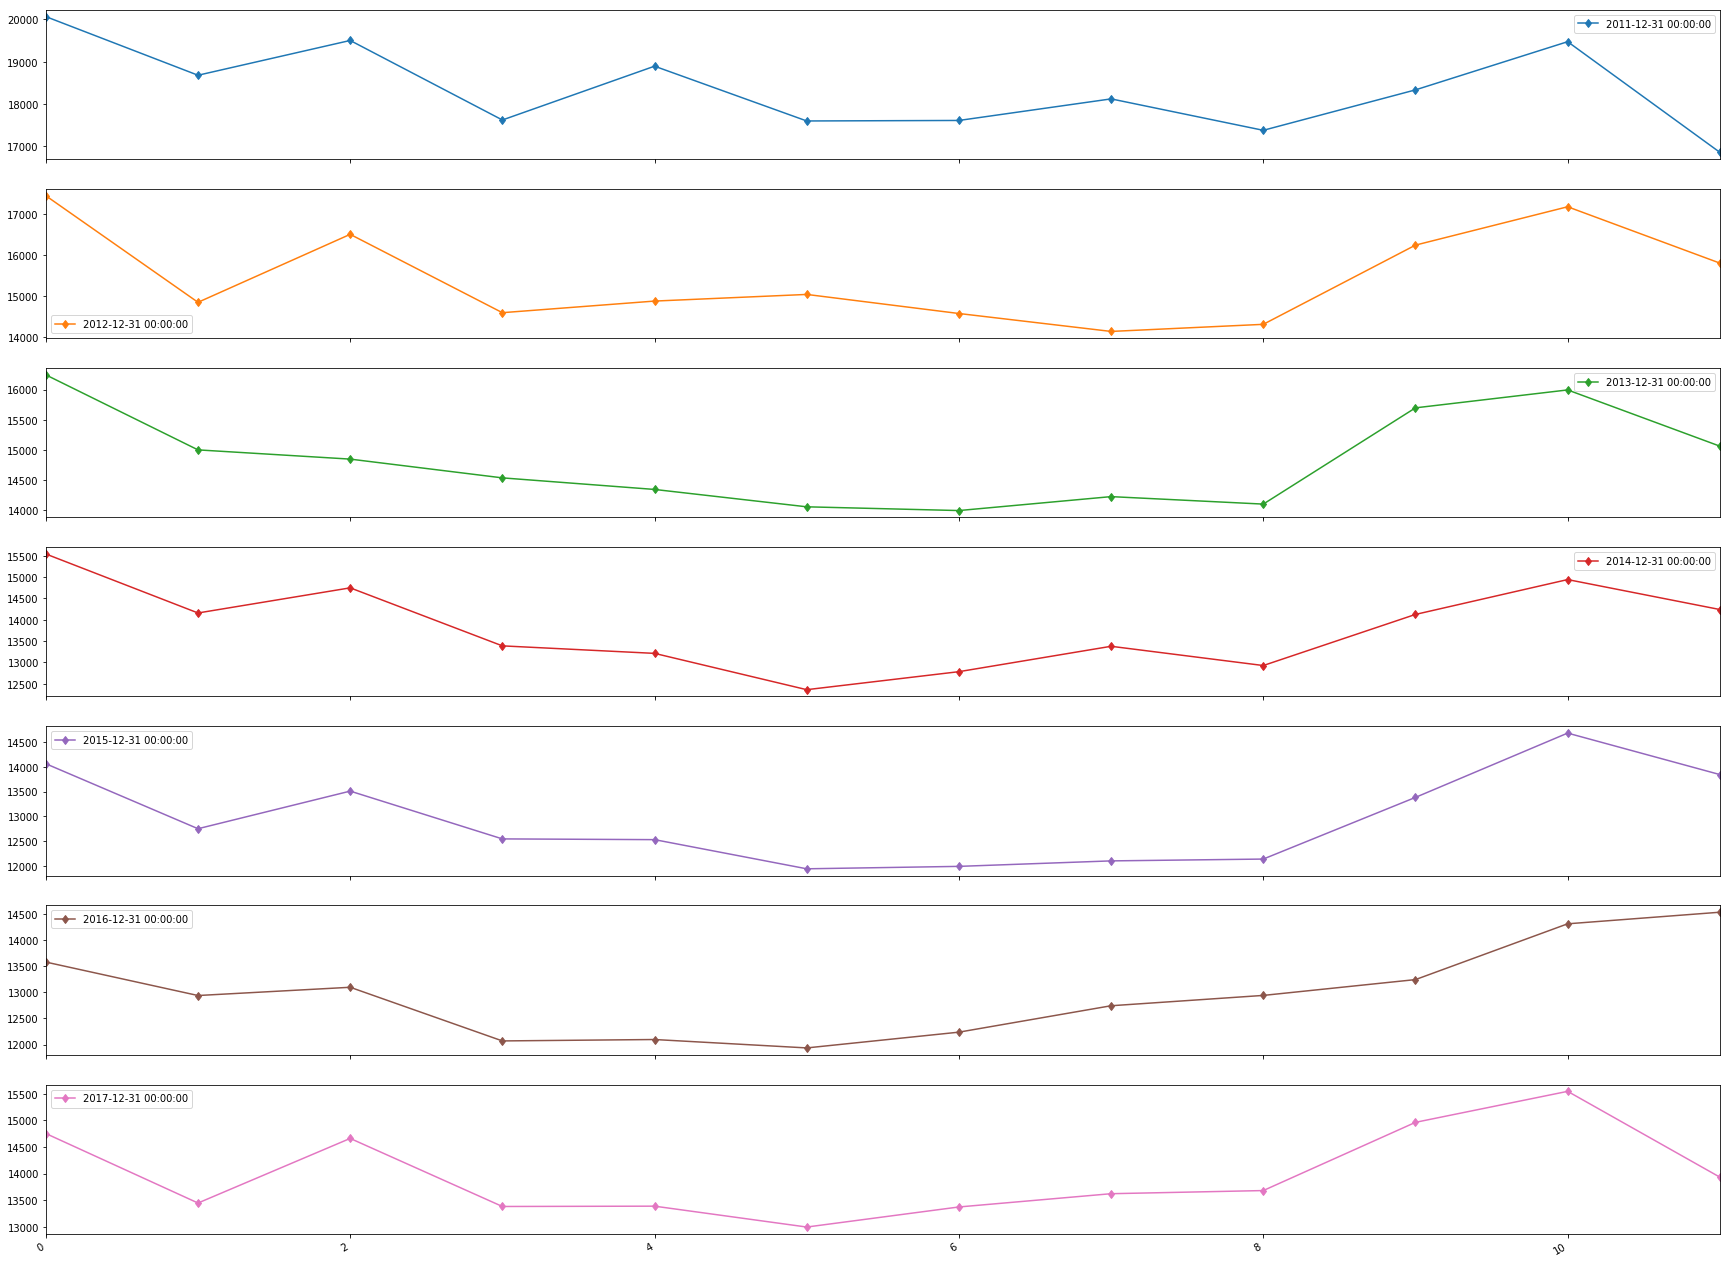

In [23]:
groupDF.plot(subplots=True, marker='d',  legend=True ,figsize=[30,25])
plt.show()

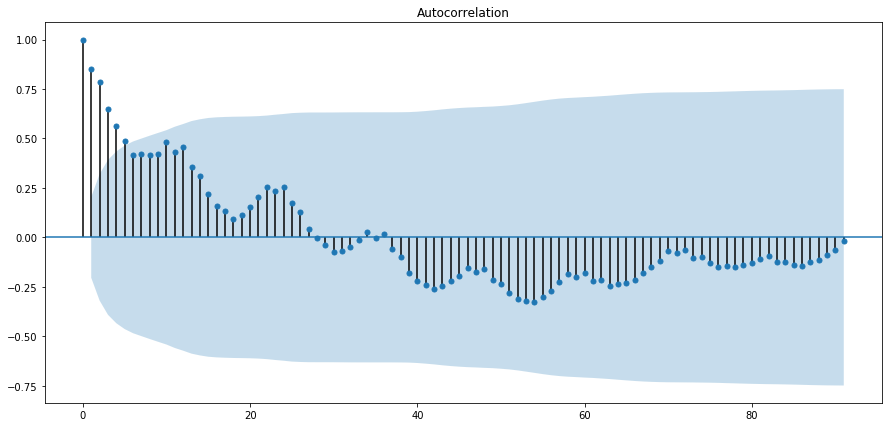

/home/student/Anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


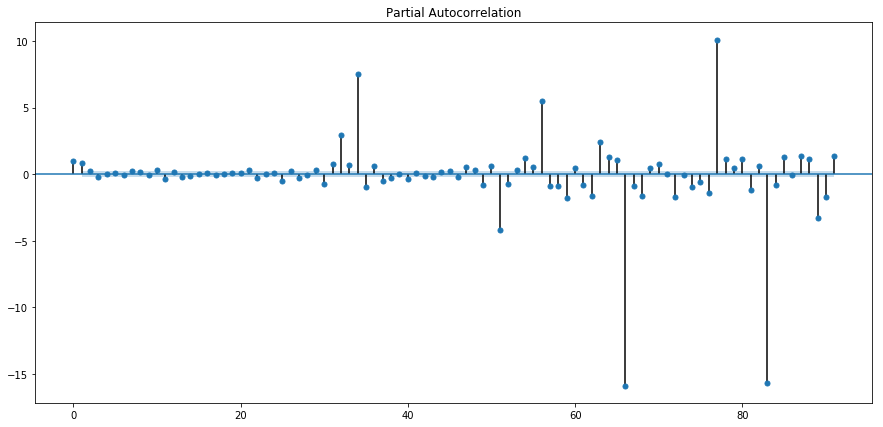

In [24]:
#sources used: https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
plot_acf(burglaries_trend)
plt.show(block=False)
plot_pacf(burglaries_trend)
pyplot.show()

/home/student/Anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/student/Anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


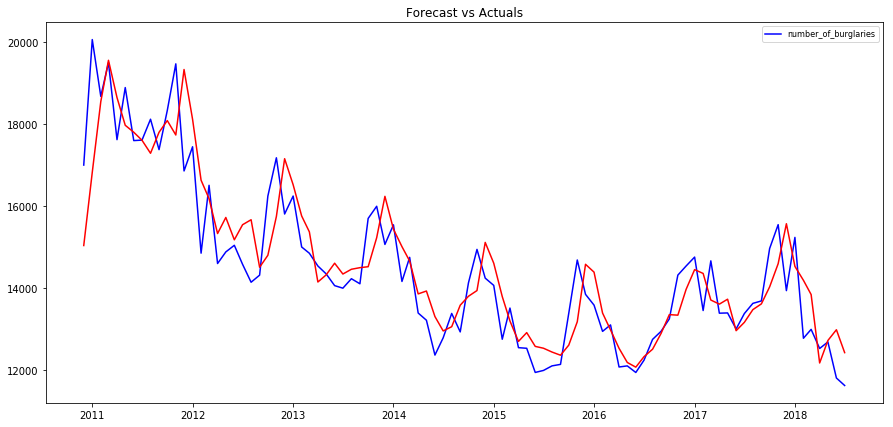

In [25]:
model = ARIMA(burglaries_trend, order=(7,0,1))
results = model.fit()
model_fit = model.fit(disp=0)
plt.plot(burglaries_trend, color='blue')
plt.plot(results.fittedvalues, color='red')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper right', fontsize=8)

In [26]:
print(model_fit.summary())

                               ARMA Model Results                               
Dep. Variable:     number_of_burglaries   No. Observations:                   92
Model:                       ARMA(7, 1)   Log Likelihood                -750.996
Method:                         css-mle   S.D. of innovations            834.681
Date:                  Mon, 20 Jan 2020   AIC                           1521.992
Time:                          13:07:30   BIC                           1547.210
Sample:                      12-01-2010   HQIC                          1532.170
                           - 07-01-2018                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       1.504e+04   1817.061      8.275      0.000    1.15e+04    1.86e+04
ar.L1.number_of_burglaries     1.1064      0.192      5.769      0.

In [27]:
train = burglaries_trend[:85]
test = burglaries_trend[85:]

In [28]:
model = ARIMA(train, order=(5, 0, 1))  
fitted = model.fit()  

/home/student/Anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [29]:

fc, se, conf = fitted.forecast(len(test), alpha=0.05)  # 95% conf

In [30]:
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

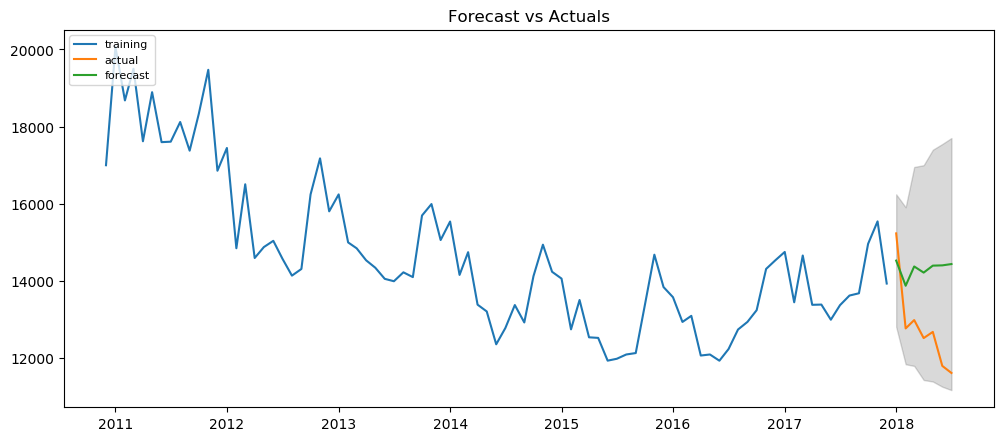

In [31]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [32]:
#10 postcodes with largest number of burglaries in January of 2018
pc=data_clean[data_clean.Month == 1].nlargest(10, 'number_of_burglaries')
pc=pc['PostCode'].to_numpy()

In [33]:
largest_burglaries= data_clean[data_clean.PostCode.isin(pc)]

In [34]:
largest_burglaries=largest_burglaries.groupby(['Month', 'PostCode']).agg({'number_of_burglaries': 'sum'})#.sort_values(by=[largest_burglaries.index.names[0],'number_of_burglaries'], ascending=False)
#data with 10 postcodes with largest number of burglaries in January of 2018

/home/student/Anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:1801: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fae27178630>,
      dtype=object)

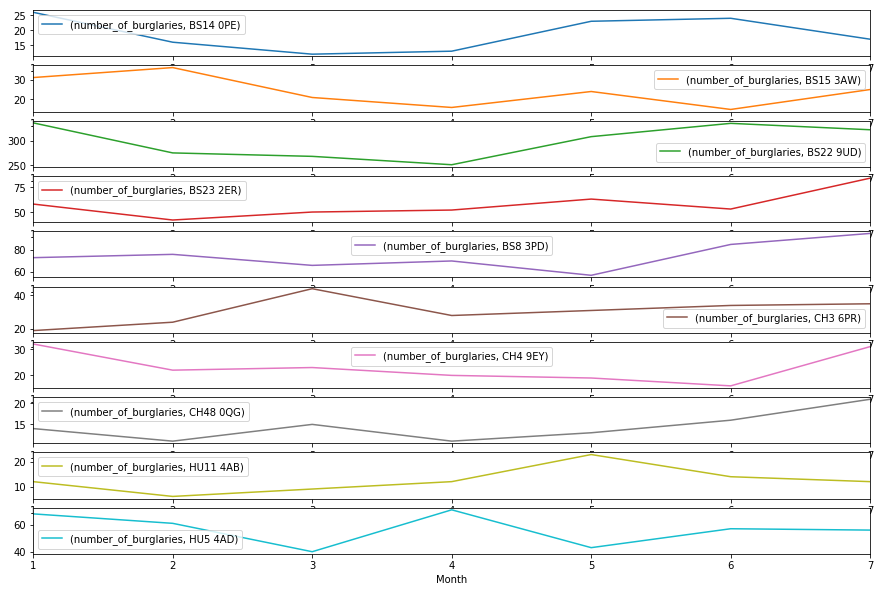

In [35]:
fig, ax = plt.subplots(figsize=(15,10))
#legend=largest_burglaries.index.get_level_values(1)[:10]
largest_burglaries.unstack().plot(subplots=True, ax=ax)


In [36]:
postcodes=data_clean[(data_clean.PostCode == 'BS22 9UD') | (data_clean.PostCode == 'BS23 2ER') | (data_clean.PostCode == 'BS8 3PD')| (data_clean.PostCode == 'CH3 6PR')]

In [37]:
data_clean['avg(price)'].describe()

count    1.960000e+02
mean     3.848243e+05
std      3.015024e+05
min      8.000000e+04
25%      1.762500e+05
50%      3.037500e+05
75%      4.603750e+05
max      1.235000e+06
Name: avg(price), dtype: float64

In [38]:
postcodes['avg(price)'][:4]

0    417500.0
1    988580.0
3     80000.0
7    460000.0
Name: avg(price), dtype: float64

In [ ]:
#it is evident that number of burglaries is increasing in those partiucular areas, 
#that are areas of relative deprivation and middle-class areas